In [1]:
# libraries for data exploration.
import pandas as pd
import numpy as np
#import matplotlib.pyplot as plt
import seaborn as sns

# library for splitting data.
from sklearn.model_selection import train_test_split

# libraries for preparing the data.
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

# libraries for building linear models.
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

# library for measuring error. 
from sklearn.metrics import mean_squared_error

# time series specific libararies
from scipy.signal import periodogram
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

# user defined.
from helpful_functions import MLFunctions
from plot_setup import plt

In [3]:
# load sales data.
sales = pd.read_csv("../../../Data/future_sales/sales_train.csv",
                    usecols=['date', 'shop_id', 'item_id', 'item_price', 'item_cnt_day'],
                    index_col='date',
                    parse_dates=['date'])

In [4]:
sales.index = pd.to_datetime(sales.index, format="%d.%m.%Y")
sales.index = sales.index.to_period('D')
sales = sales.sort_index()

In [6]:
sales.head()

,shop_id,item_id,item_price,item_cnt_day
date,,,,
2013-01-01,18,5823,2500.0,1.0
2013-01-01,27,5573,849.0,1.0
2013-01-01,7,1006,399.0,1.0
2013-01-01,19,17707,899.0,1.0
2013-01-01,14,19548,149.0,1.0


In [9]:
helper_function = MLFunctions(sales)
arr = helper_function.dateNum()

In [10]:
sales['time'] = arr

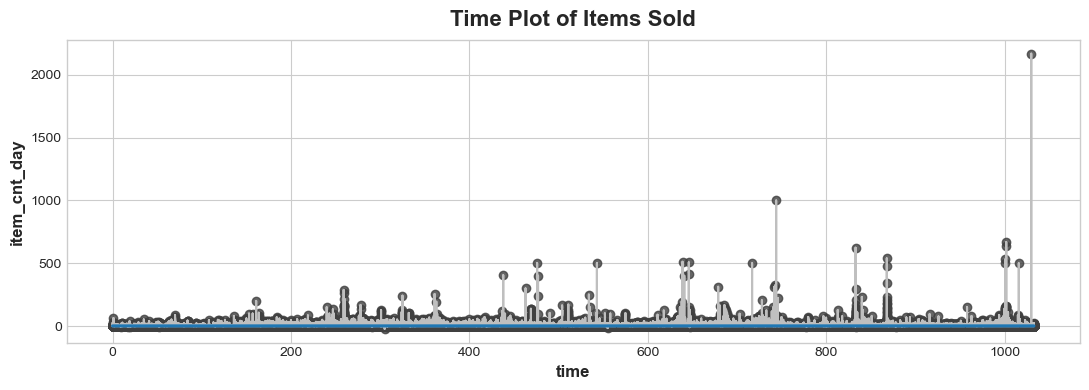

In [29]:
fig, ax = plt.subplots()
ax.plot('time', 'item_cnt_day', data=sales, color='0.75')
ax = sns.regplot(x='time', y='item_cnt_day', data=sales, ci=None, scatter_kws=dict(color='0.25'))
ax.set_title('Time Plot of Items Sold');

In [8]:
#sales = sales.groupby(['date', 'shop_id']).mean()
sales = sales.groupby(['date']).mean()

In [15]:
X = sales.loc[:, ['time']]
y = sales.loc[:, 'item_cnt_day']

In [17]:
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [19]:
y_pred = pd.Series(model.predict(X), index=X.index)

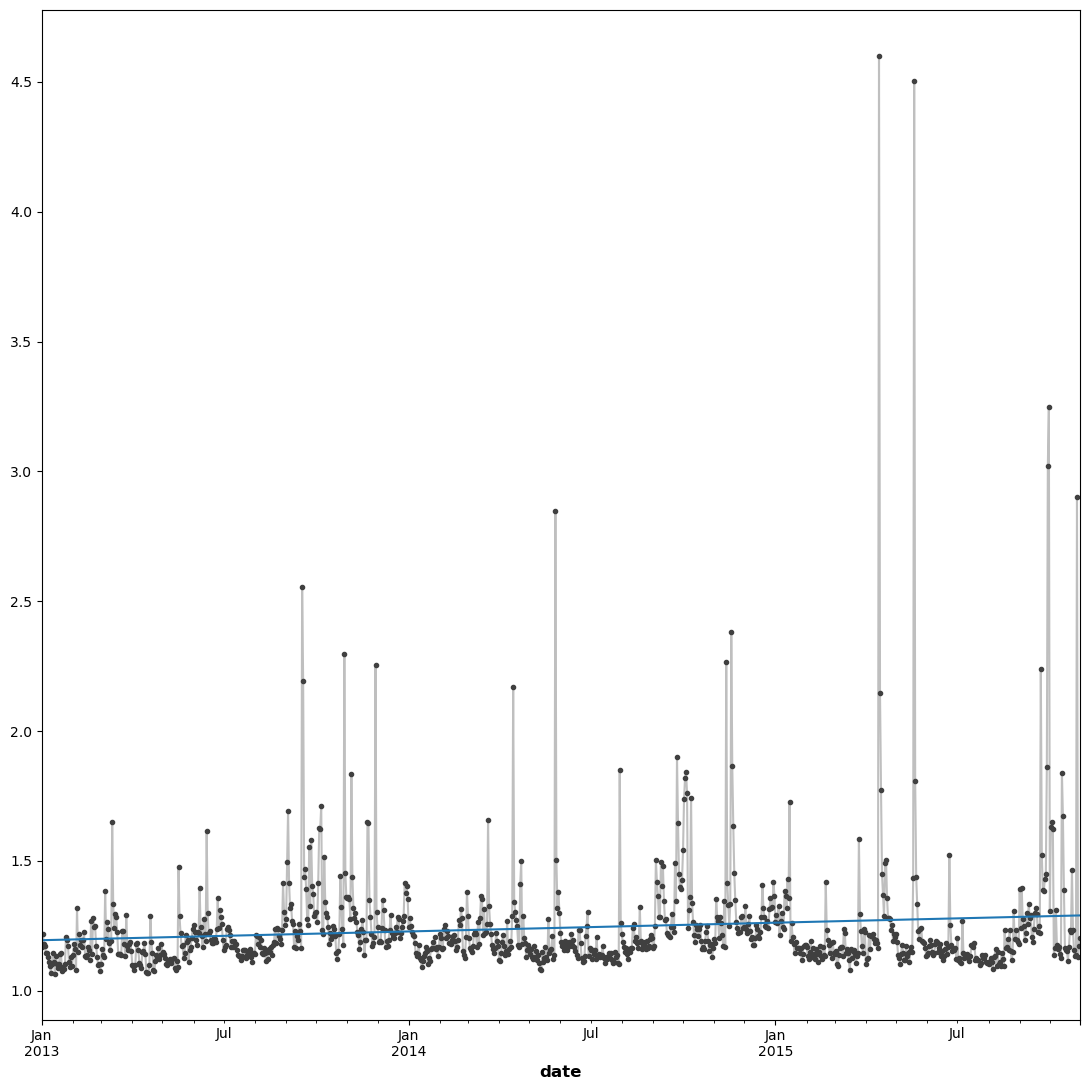

In [21]:
ax = y.plot(**plot_params)
ax = y_pred.plot(ax=ax)

In [23]:
lag_1 = sales['item_cnt_day'].shift(1)
sales['lag_1'] = lag_1
X = sales.loc[:, ['lag_1']].dropna()
y = sales.loc[:, 'item_cnt_day']

In [25]:
y, X = y.align(X, join='inner')

In [27]:
sales.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,dummy_time,lag_1
date,,,,,,,
2013-01-01,0.0,32.615938,10274.460755,726.050703,1.168963,0,NaN
2013-01-02,0.0,32.291158,10096.038404,758.981735,1.220304,1,1.168963
2013-01-03,0.0,30.078914,10123.393617,740.650622,1.178469,2,1.220304
2013-01-04,0.0,29.804934,10183.369720,737.073209,1.174476,3,1.178469
2013-01-05,0.0,29.546799,10195.478269,735.039395,1.144454,4,1.174476


In [29]:
model2 = LinearRegression()
model2.fit(X,y)

LinearRegression()

In [31]:
y_pred = pd.Series(model2.predict(X), index=X.index)

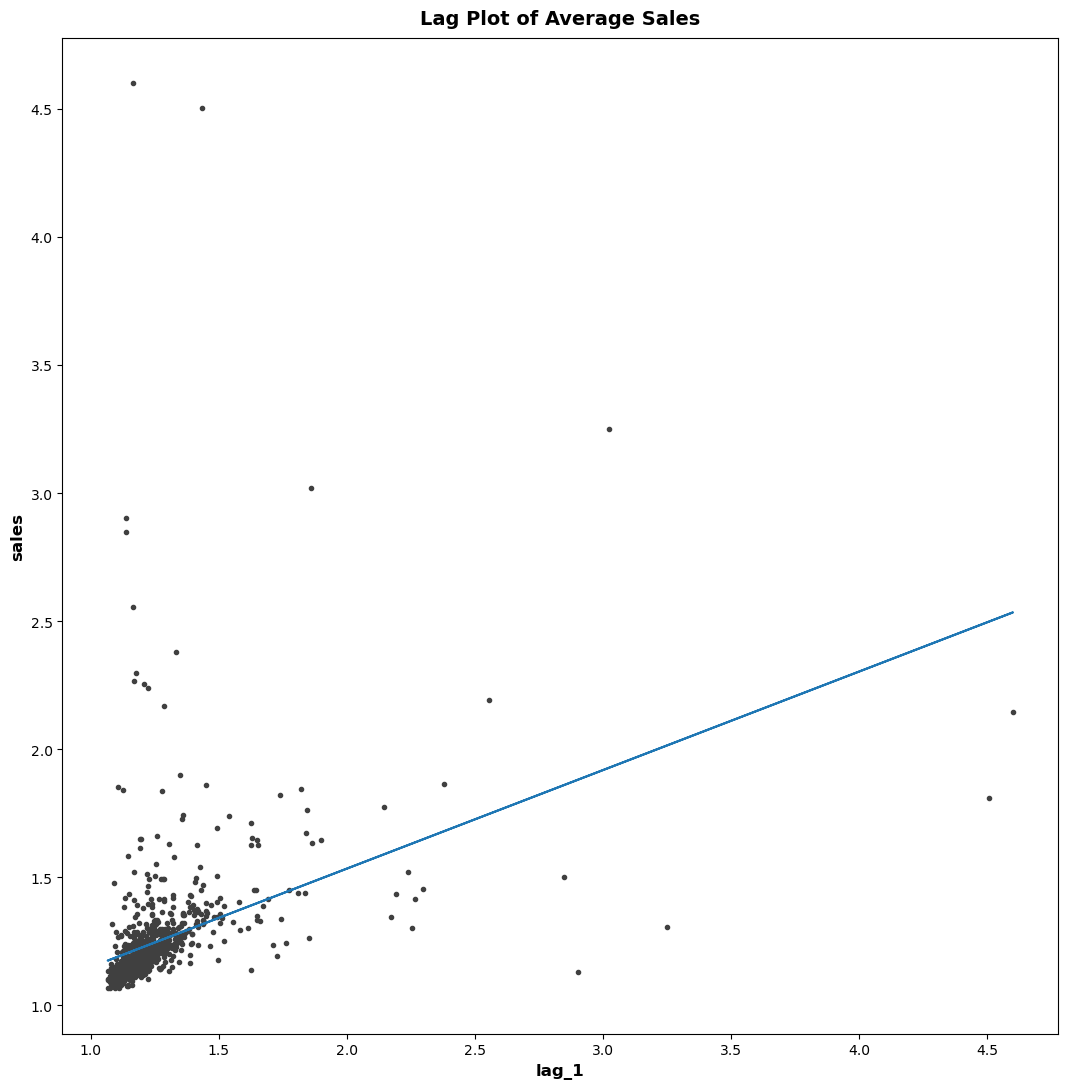

In [33]:
fig, ax = plt.subplots()
ax.plot(X['lag_1'], y, '.', color='0.25')
ax.plot(X['lag_1'], y_pred)
ax.set(aspect='equal', ylabel='sales', xlabel='lag_1', title='Lag Plot of Average Sales');

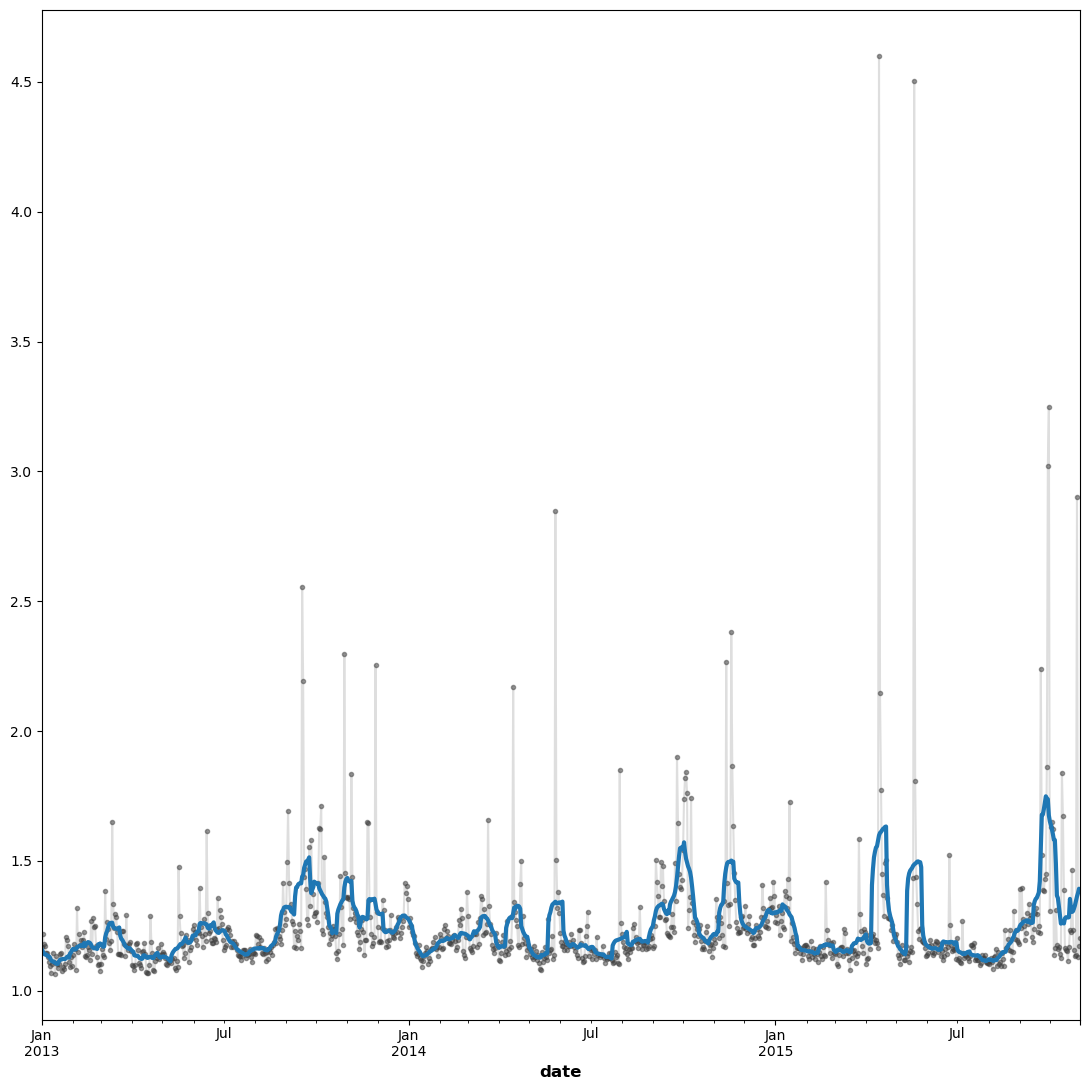

In [35]:
trend = sales['item_cnt_day'].rolling(
    window=15,
    center=True,
    min_periods=7
    ).mean()

# Make a plot
ax = sales['item_cnt_day'].plot(**plot_params, alpha=0.5)
ax = trend.plot(ax=ax, linewidth=3)

In [39]:
sales = sales.asfreq('D')

In [41]:
from statsmodels.tsa.deterministic import DeterministicProcess

y = sales['item_cnt_day'].copy()  # the target

dp = DeterministicProcess(
    index=y.index,
    order=3
)

# YOUR CODE HERE: Create the feature set for the dates given in y.index
X = dp.in_sample()

# YOUR CODE HERE: Create features for a 30-day forecast.
X_fore = dp.out_of_sample(steps=30)


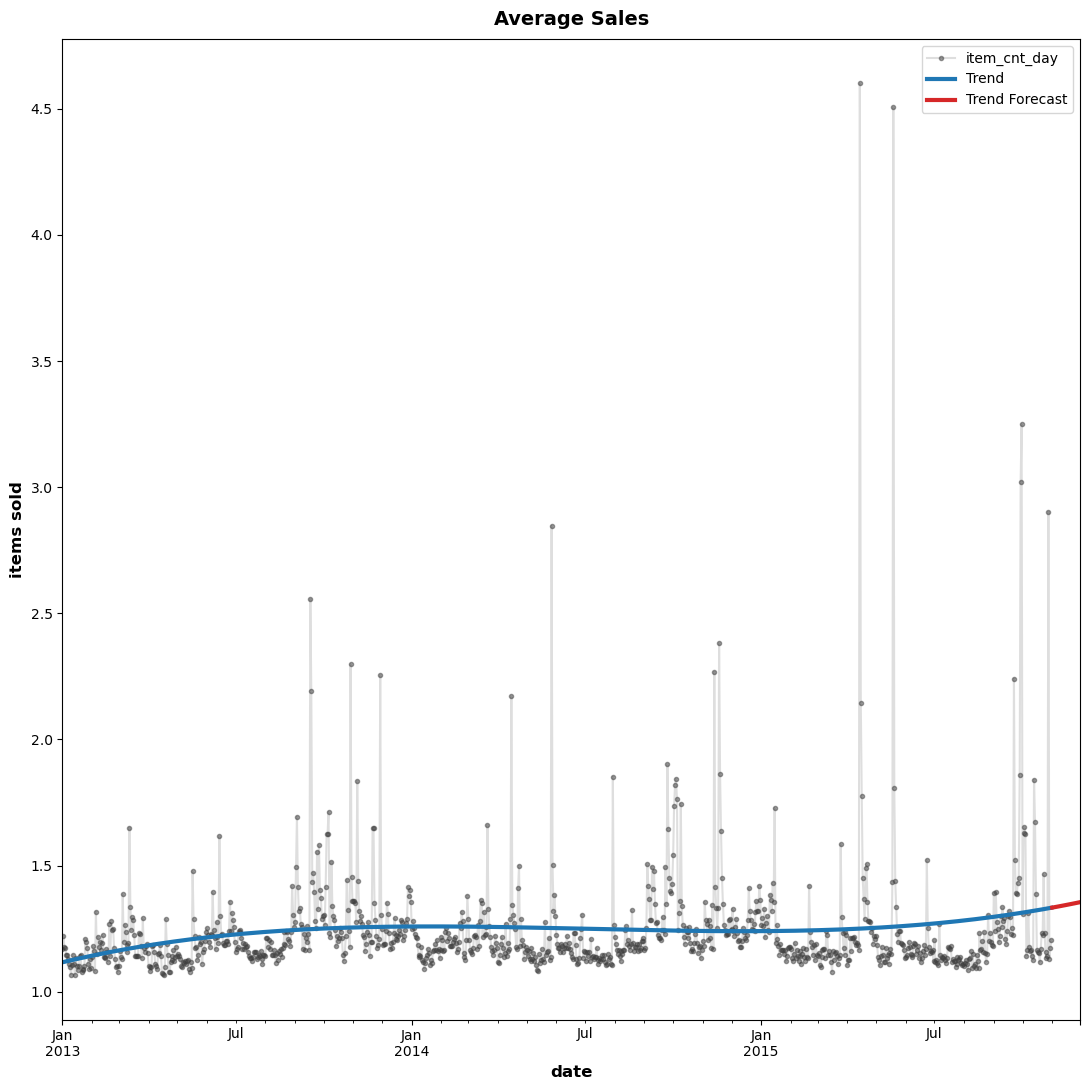

In [43]:
model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color='C3')
ax.legend();

In [39]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        errorbar=('ci', False),
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

In [41]:
def plot_periodogram(ts, detrend='linear', ax=None):
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

In [43]:
average_sales = (
    sales
    .groupby('date').mean()
    .squeeze()
    .loc['2015']
)

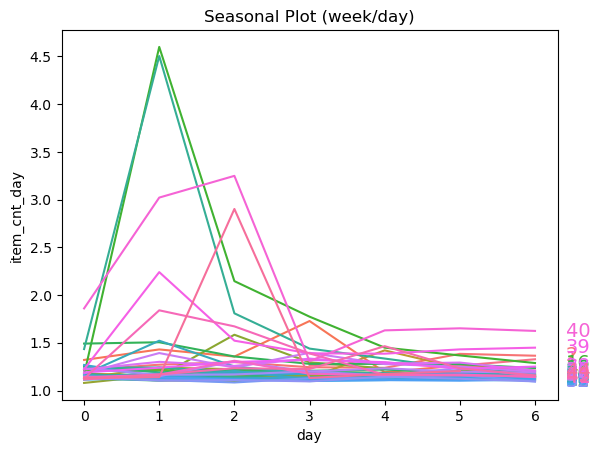

In [45]:
X = average_sales
X["week"] = X.index.week
X["day"] = X.index.dayofweek
seasonal_plot(X, y='item_cnt_day', period='week', freq='day');

ValueError: x and y must have same first dimension, but have shapes (4,) and (304, 4)

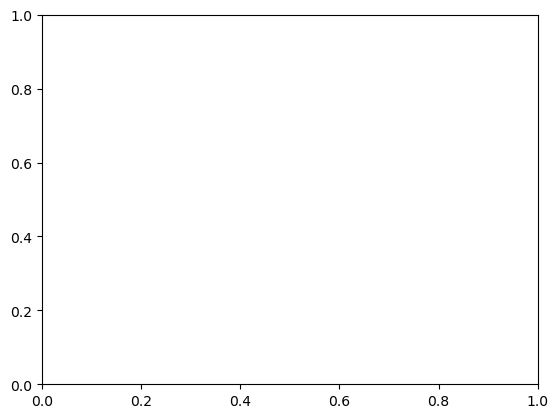

In [47]:
plot_periodogram(average_sales)